# Training a Neural Network

As we've seen, the Network we built in the previous notebook wasn't very smart. The previous Network was quite naive, in order to solve this issue, what we do is we feed real data into the network and we adjust the parameters of the network such that when given another input it approximately predicts the right answer.

To do this we need to first find out how badly the current network predicts the answers, for this we calculate something called as the **Loss Function**, it is a measure of the prediction error of our network. For example the mean squared loss is generally used in regression and binary classification problems.

$$
\large \ell = \frac{1}{2n}\sum_i^n{\left(y_i - \hat{y}_i\right)^2}
$$

where $n$ is the number of training examples, $y_i$ are the true labels, and $\hat{y}_i$ are the predicted labels.

By minimizing this loss, we can find at which point will the network make the least amount of errors i.e predict correct labels for a given input with the highest accuracy. We reach this minimum by a process called ***Gradient Descent***. The gradient is the slope of the loss function and points in the direction of highest change. Think of gradient descent as someone trying to climb down a mountain in the least amount of time, by following the steepest slope to the base.

<img src="assets/gradient_descent.png" width=400px>

## Backpropagation

Implementing gradient descent on single layer neural networks is easy, but it gets complicated on multilayer neural networks, like the one we built.

Backpropagation is essentially just an application of the chain rule of the chain rule from calculus.

1. We perform a forward pass and calculate the loss (also called the cost)

<img src="assets/forwardpass.png" width=600px>

2. Once the loss is calculated we use the chain rule to find the gradient.

$$
\large \frac{\partial \ell}{\partial W_1} = \frac{\partial L_1}{\partial W_1} \frac{\partial S}{\partial L_1} \frac{\partial L_2}{\partial S} \frac{\partial \ C}{\partial L_2}
$$

3. Now we backpropagate, and update the weights.

<img src="assets/backpropagation1.png" width=600px>

What about layers further back? To calculate the gradient for w​1​ we use the same method as before, walking backwards through the graph, so the derivative calculations look like this:

<img src="assets/backpropagation2.png" width=600px>


## Losses in PyTorch

PyTorch offers us the `nn` module to calculate the loss. It contains losses such as the cross-entropy loss (`nn.CrossEntropyLoss`) which we assign to `criterion`. 

Something really important to note here. Looking at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

This means we need to pass in the raw output of our network into the loss, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually best to avoid doing calculations with probabilities, typically we use log-probabilities.


In [14]:
#Import Modules and the Data
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [15]:
# Build a feed-forward network
model = nn.Sequential(nn.Linear(784, 128),
                      nn.ReLU(),
                      nn.Linear(128, 64),
                      nn.ReLU(),
                      nn.Linear(64, 10))

# Define the loss
criterion = nn.CrossEntropyLoss()

# Get our data
images, labels = next(iter(trainloader))
# Flatten images
images = images.view(images.shape[0], -1)

# Forward pass, get our logits
logits = model(images)
# Calculate the loss with the logits and the labels
loss = criterion(logits, labels)

print(loss)

tensor(2.3026, grad_fn=<NllLossBackward>)


In most cases it is more convienent to build a network with a log-softmax output using `nn.LogSoftmax` or `F.log_softmax` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.LogSoftmax)). Then you can get the actual probabilities by taking the exponential `torch.exp(output)`. With a log-softmax output, you want to use the negative log likelihood loss, `nn.NLLLoss` ([documentation](https://pytorch.org/docs/stable/nn.html#torch.nn.NLLLoss)).

We will build this network shortly.

## How do we use this knowledge to perform backpropagation ?

Torch provides a module, `autograd`, for automatically calculating the gradients of tensors. We can use it to calculate the gradients of all our parameters with respect to the loss. Autograd works by keeping track of operations performed on tensors, then going backwards through those operations, calculating gradients along the way. To make sure PyTorch keeps track of operations on a tensor and calculates the gradients, you need to set `requires_grad = True` on a tensor. You can do this at creation with the `requires_grad` keyword, or at any time with `x.requires_grad_(True)`.

The gradients are computed with respect to some variable `z` with `z.backward()`. This does a backward pass through the operations that created `z`.

## Updating the weights

Well we now know how to find the loss and to calculate the gradients, but how do we update the weights? 

For this we require an optimizer that we'll use to update the weights with the gradients. We get these from PyTorch's [`optim` package](https://pytorch.org/docs/stable/optim.html). For example we can use stochastic gradient descent with `optim.SGD`. You can see how to define an optimizer below.

In [16]:
from torch import optim

# Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Let's Train our Network !!!

Now that we've learnt how to train a network let's put in use.

In [19]:
# Write a model and train it
model = nn.Sequential(nn.Linear(784,128),
                     nn.ReLU(),
                     nn.Linear(128,64),
                     nn.ReLU(),
                     nn.Linear(64,10),
                     nn.LogSoftmax())

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

epochs = 5

for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        images = images.view(images.shape[0],-1)
        
        #training pass
        optimizer.zero_grad()
        output=model(images)
        loss=criterion(output,labels)
        loss.backward()
        
        running_loss+=loss.item()
        optimizer.step()
    



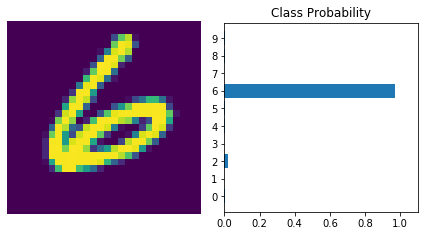

In [21]:
#Viewing results
%matplotlib inline
import helper

images, labels=next(iter(trainloader))
img= images[0].view(1,784)
with torch.no_grad():
    logps = model(img)
    
ps= torch.exp(logps)
helper.view_classify(img.view(1,28,28),ps)
